# Development Dataset Analysis – AAT3
## Statistical Significance Deep Dive

## 1. Setup
Import core libraries and configure global plotting aesthetics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import re
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)

## 2. Data Loading and Cleaning
Prepare a tidy analysis table from the raw survey export.

In [3]:
raw_df = pd.read_csv("Dev_ATT.csv")
df = raw_df.copy()
df.columns = df.columns.str.strip()

drop_candidates = [
    "Sex","School failure","WhatsApp","Facebook","Instagram","Twitter","Snapchat","TikTok",
    "Other social","Time spent on social media","Daily use of social media","Which device","Time's flow",
    "Perceived anxiety during SM use","Perceived loneliness","SM checking","Video-games and online play",
    "Time spent on line playng videogames"
 ]
df = df.drop(columns=drop_candidates, errors="ignore")

rename_map = {
    "Sex.1": "Sex","School Failure": "School Failure","Yes/No": "WhatsApp","Yes/No.1": "Facebook",
    "Yes/No.2": "Instagram","Yes/No.3": "Twitter","Yes/NO": "Snapchat","Yes/No.4": "TikTok",
    "Yes/No.5": "Other social","Unnamed: 20": "Time spent on social media","Yes/No.6": "Daily use of social media",
    "Unnamed: 24": "Device","Unnamed: 26": "Time's flow","Unnamed: 28": "Perceived anxiety",
    "Unnamed: 30": "Perceived loneliness","Unnamed: 32": "SM checking","Unnamed: 34": "Video games",
    "Unnamed: 36": "Videogame time","BSMAS cut-off underlined": "BSMAS cut-off"," STAI Y-1": "STAI Y-1"
}
df = df.rename(columns=rename_map)
df.columns = df.columns.str.strip()

def normalize_sex(value: object) -> str:
    if pd.isna(value):
        return np.nan
    text = str(value).strip().lower()
    mapping = {"1": "Male","2": "Female","m": "Male","f": "Female"}
    text = mapping.get(text, text)
    return text.title()

df["Sex"] = df["Sex"].apply(normalize_sex)

yes_no_columns = [
    "WhatsApp","Facebook","Instagram","Twitter","Snapchat","TikTok","Other social",
    "Daily use of social media"
 ]

def normalize_yes_no(value: object) -> object:
    if pd.isna(value):
        return np.nan
    text = str(value).strip().lower()
    if text in {"1","yes","y"}:
        return "Yes"
    if text in {"0","no","n"}:
        return "No"
    return str(value).strip()

for col in yes_no_columns:
    if col in df.columns:
        df[col] = df[col].apply(normalize_yes_no)

numeric_columns = [
    "Age","BSMAS","BSMAS cut-off","RSES","CSIQ-A","STAI Y-1","STAI Y-2"
 ]
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

def parse_time_band(value: object) -> float:
    if pd.isna(value):
        return np.nan
    text = str(value).strip()
    if "<" in text:
        return 0.5
    digits = re.findall(r"\d+", text)
    if not digits:
        return np.nan
    numbers = list(map(float, digits))
    if len(numbers) == 1:
        return numbers[0] + (1.0 if "more" in text.lower() else 0.0)
    return float(np.mean(numbers))

df["Social_media_hours"] = df.get("Time spent on social media", pd.Series(dtype="object")).apply(parse_time_band)
df["Videogame_hours"] = df.get("Videogame time", pd.Series(dtype="object")).apply(parse_time_band)

df["BSMAS_risk_flag"] = np.where(df["BSMAS"] >= df["BSMAS cut-off"], 1, 0)
df["BSMAS_risk_label"] = np.where(df["BSMAS_risk_flag"] == 1, "At/Above cut-off", "Below cut-off")

usage_source = df["Social_media_hours"].dropna()
if usage_source.nunique() >= 3:
    df["Usage_Category"] = pd.qcut(usage_source, 3, labels=["Low","Medium","High"])
elif usage_source.nunique() > 0:
    df["Usage_Category"] = pd.cut(usage_source, 3, labels=["Low","Medium","High"])
else:
    df["Usage_Category"] = np.nan

display_cols = [col for col in ["Age","Sex","BSMAS","BSMAS cut-off","Social_media_hours","Usage_Category","Daily use of social media","Device"] if col in df.columns]
df[display_cols].head()

,Age,Sex,BSMAS,BSMAS cut-off,Social_media_hours,Usage_Category,Daily use of social media,Device
0,18,Female,16,16,9.0,High,Yes,Smartphone
1,19,Female,9,9,3.0,Low,Yes,Smartphone
2,18,Male,21,21,5.0,Medium,Yes,Smartphone
3,17,Male,12,12,11.0,High,Yes,Smartphone and computer
4,17,Male,11,11,3.0,Low,Yes,Smartphone


## 3. Statistical Significance Tests
Testing key behavioural hypotheses using the cleaned dataset.

### 3.1 Chi-Square Tests (Categorical × Categorical)
Evaluate independence between platform habits and risk indicators.

In [4]:
chi_tests = [
    ("Daily social media use vs BSMAS risk", "Daily use of social media", "BSMAS_risk_label"),
    ("Device type vs BSMAS risk", "Device", "BSMAS_risk_label"),
    ("Sex vs Daily social media use", "Sex", "Daily use of social media")
 ]
chi_records = []
for description, col_a, col_b in chi_tests:
    if col_a in df.columns and col_b in df.columns:
        subset = df[[col_a, col_b]].dropna()
        if subset[col_a].nunique() > 1 and subset[col_b].nunique() > 1:
            contingency = pd.crosstab(subset[col_a], subset[col_b])
            chi2_stat, p_value, dof, _ = chi2_contingency(contingency)
            chi_records.append({
                "Test": description,
                "Chi2": chi2_stat,
                "p_value": p_value,
                "Degrees_of_freedom": dof,
                "Significant (p<0.05)": "Yes" if p_value < 0.05 else "No"
            })
        else:
            chi_records.append({
                "Test": description,
                "Chi2": np.nan,
                "p_value": np.nan,
                "Degrees_of_freedom": np.nan,
                "Significant (p<0.05)": "Insufficient variability"
            })
    else:
        chi_records.append({
            "Test": description,
            "Chi2": np.nan,
            "p_value": np.nan,
            "Degrees_of_freedom": np.nan,
            "Significant (p<0.05)": "Column missing"
        })

chi_results = pd.DataFrame(chi_records)
chi_results

,Test,Chi2,p_value,Degrees_of_freedom,Significant (p<0.05)
0,Daily social media use vs BSMAS risk,NaN,NaN,NaN,Insufficient variability
1,Device type vs BSMAS risk,NaN,NaN,NaN,Insufficient variability
2,Sex vs Daily social media use,0.563038,0.453039,1.0,No


### 3.2 Independent Samples T-Tests (Numeric × Binary Groups)
Compare psychological scores across key binary factors.

In [5]:
ttest_specs = [
    ("BSMAS by Sex", "BSMAS", "Sex", ("Female", "Male")),
    ("STAI Y-1 by daily usage", "STAI Y-1", "Daily use of social media", ("Yes", "No")),
    ("RSES by daily usage", "RSES", "Daily use of social media", ("Yes", "No"))
 ]
ttest_records = []
for description, metric_col, group_col, labels in ttest_specs:
    if metric_col in df.columns and group_col in df.columns:
        subset = df[[metric_col, group_col]].dropna()
        group_samples = []
        valid_groups = True
        group_sizes = {}
        group_means = {}
        for label in labels:
            sample = pd.to_numeric(subset.loc[subset[group_col] == label, metric_col], errors="coerce").dropna()
            group_sizes[label] = sample.shape[0]
            group_means[label] = sample.mean() if not sample.empty else np.nan
            if sample.empty:
                valid_groups = False
            group_samples.append(sample)
        if valid_groups and len(group_samples) == 2:
            t_stat, p_val = ttest_ind(group_samples[0], group_samples[1], nan_policy="omit", equal_var=False)
            ttest_records.append({
                "Test": description,
                "Group A": labels[0],
                "Group B": labels[1],
                "Mean A": group_means[labels[0]],
                "Mean B": group_means[labels[1]],
                "Mean Difference": group_means[labels[0]] - group_means[labels[1]],
                "T_stat": t_stat,
                "p_value": p_val,
                "Significant (p<0.05)": "Yes" if p_val < 0.05 else "No",
                "n_A": group_sizes[labels[0]],
                "n_B": group_sizes[labels[1]]
            })
        else:
            ttest_records.append({
                "Test": description,
                "Group A": labels[0],
                "Group B": labels[1],
                "Mean A": np.nan,
                "Mean B": np.nan,
                "Mean Difference": np.nan,
                "T_stat": np.nan,
                "p_value": np.nan,
                "Significant (p<0.05)": "Insufficient data",
                "n_A": group_sizes.get(labels[0], 0),
                "n_B": group_sizes.get(labels[1], 0)
            })
    else:
        ttest_records.append({
            "Test": description,
            "Group A": labels[0],
            "Group B": labels[1],
            "Mean A": np.nan,
            "Mean B": np.nan,
            "Mean Difference": np.nan,
            "T_stat": np.nan,
            "p_value": np.nan,
            "Significant (p<0.05)": "Column missing",
            "n_A": np.nan,
            "n_B": np.nan
        })

ttest_results = pd.DataFrame(ttest_records)
ttest_results

,Test,Group A,Group B,Mean A,Mean B,Mean Difference,T_stat,p_value,Significant (p<0.05),n_A,n_B
0,BSMAS by Sex,Female,Male,13.436242,12.568807,0.867434,1.536903,0.125685,No,149,109
1,STAI Y-1 by daily usage,Yes,No,43.295359,45.857143,-2.561784,-1.622286,0.118764,No,237,21
2,RSES by daily usage,Yes,No,16.493671,17.666667,-1.172996,-1.116228,0.275144,No,237,21


### 3.3 One-Way ANOVA (Numeric × Multi-Level Usage)
Assess mean differences across low/medium/high usage strata.

In [6]:
anova_specs = [
    ("BSMAS across usage bands", "BSMAS", "Usage_Category"),
    ("STAI Y-1 across usage bands", "STAI Y-1", "Usage_Category"),
    ("RSES across usage bands", "RSES", "Usage_Category")
 ]
anova_records = []
for description, metric_col, category_col in anova_specs:
    if metric_col in df.columns and category_col in df.columns:
        subset = df[[metric_col, category_col]].dropna()
        grouped = []
        group_labels = []
        for label, series in subset.groupby(category_col):
            numeric_series = pd.to_numeric(series[metric_col], errors="coerce").dropna()
            if numeric_series.empty:
                continue
            grouped.append(numeric_series)
            group_labels.append(label)
        if len(grouped) >= 2:
            f_stat, p_val = f_oneway(*grouped)
            overall_mean = pd.concat(grouped).mean()
            ss_between = sum(len(g) * (g.mean() - overall_mean) ** 2 for g in grouped)
            ss_within = sum(((g - g.mean()) ** 2).sum() for g in grouped)
            eta_squared = ss_between / (ss_between + ss_within) if (ss_between + ss_within) > 0 else np.nan
            df_between = len(grouped) - 1
            df_within = sum(len(g) for g in grouped) - len(grouped)
            anova_records.append({
                "Test": description,
                "Groups": len(grouped),
                "df_between": df_between,
                "df_within": df_within,
                "F_stat": f_stat,
                "p_value": p_val,
                "Significant (p<0.05)": "Yes" if p_val < 0.05 else "No",
                "Eta_squared": eta_squared
            })
        else:
            anova_records.append({
                "Test": description,
                "Groups": len(grouped),
                "df_between": np.nan,
                "df_within": np.nan,
                "F_stat": np.nan,
                "p_value": np.nan,
                "Significant (p<0.05)": "Insufficient groups",
                "Eta_squared": np.nan
            })
    else:
        anova_records.append({
            "Test": description,
            "Groups": np.nan,
            "df_between": np.nan,
            "df_within": np.nan,
            "F_stat": np.nan,
            "p_value": np.nan,
            "Significant (p<0.05)": "Column missing",
            "Eta_squared": np.nan
        })

anova_results = pd.DataFrame(anova_records)
anova_results

,Test,Groups,df_between,df_within,F_stat,p_value,Significant (p<0.05),Eta_squared
0,BSMAS across usage bands,3,2,255,0.643623,0.526237,No,0.005023
1,STAI Y-1 across usage bands,3,2,255,0.563015,0.570196,No,0.004396
2,RSES across usage bands,3,2,255,8.412421,0.000290,Yes,0.061896


### 3.4 Visual Summary of p-Values
Log-scaled view of p-values for quick significance scanning.

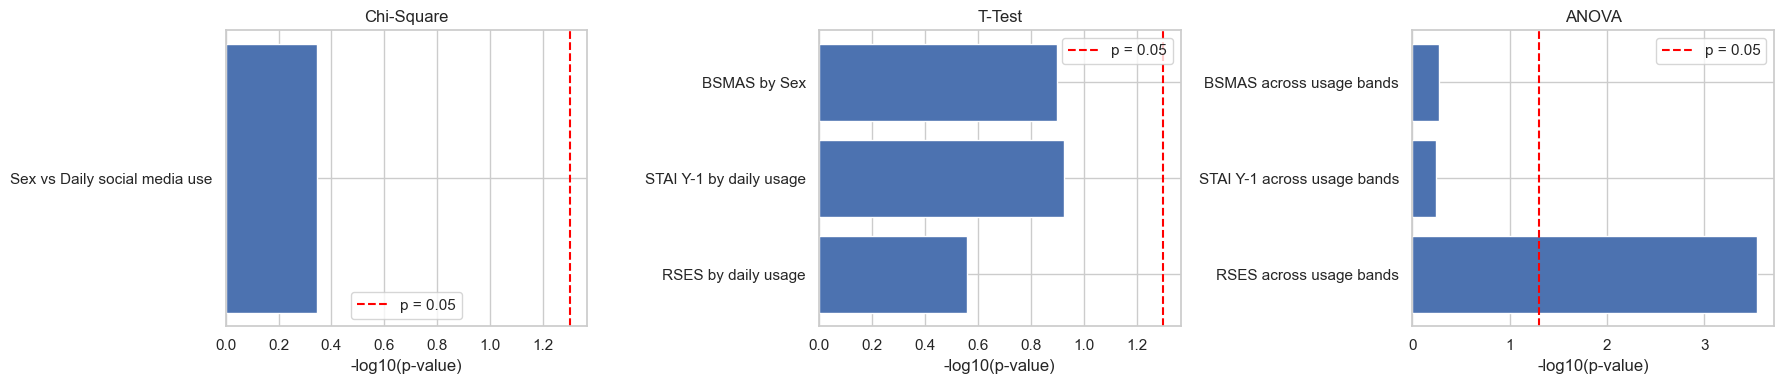

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
summary_specs = [
    (chi_results, "Test", "Chi-Square"),
    (ttest_results, "Test", "T-Test"),
    (anova_results, "Test", "ANOVA")
 ]

for ax, (frame, label_col, title) in zip(axes, summary_specs):
    if "p_value" not in frame.columns:
        ax.text(0.5, 0.5, "No p-values", ha="center", va="center", fontsize=11)
        ax.set_title(title)
        ax.axis("off")
        continue
    subset = frame.dropna(subset=["p_value"])
    if subset.empty:
        ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center", fontsize=11)
        ax.set_title(title)
        ax.axis("off")
        continue
    ax.barh(subset[label_col], -np.log10(subset["p_value"]))
    ax.axvline(-np.log10(0.05), color="red", linestyle="--", label="p = 0.05")
    ax.set_xlabel("-log10(p-value)")
    ax.set_title(title)
    ax.invert_yaxis()
    ax.legend()

plt.tight_layout()
plt.show()

## 4. Supporting Visualizations
Plots to illustrate the group differences highlighted above.

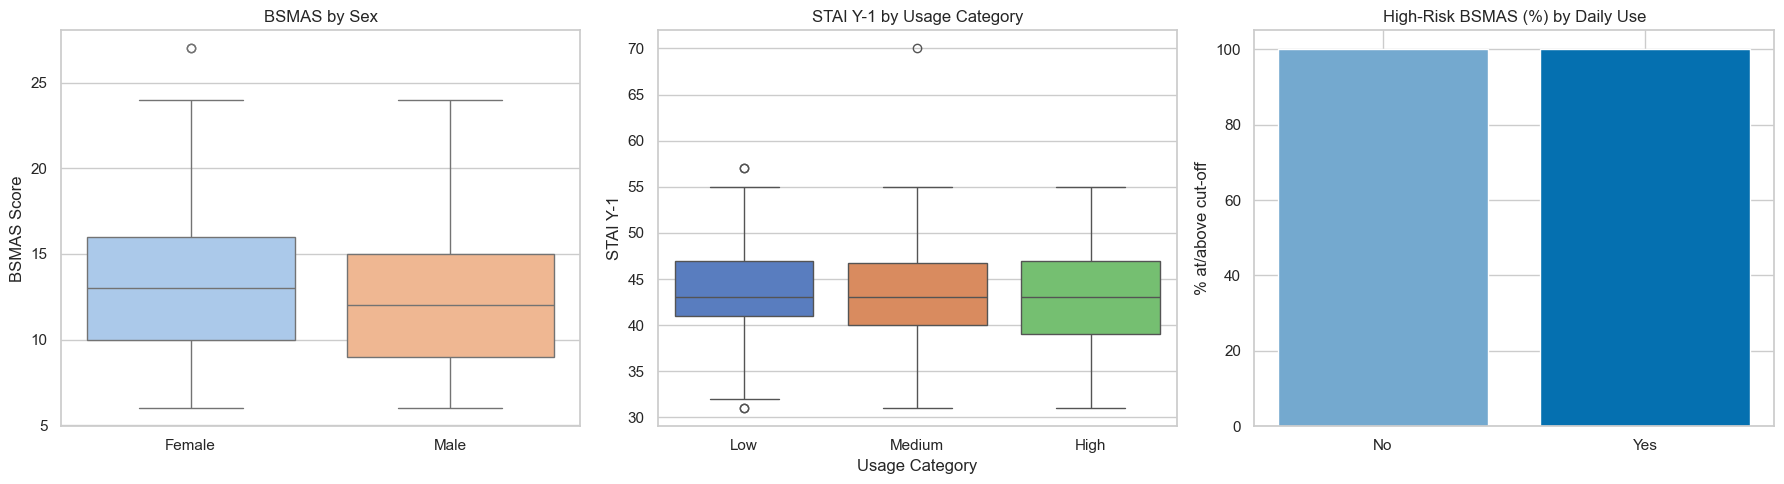

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

if {"Sex", "BSMAS"}.issubset(df.columns):
    sns.boxplot(data=df, x="Sex", y="BSMAS", hue="Sex", ax=axes[0], palette="pastel")
    axes[0].set_title("BSMAS by Sex")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("BSMAS Score")
    legend_handle = axes[0].legend_
    if legend_handle is not None:
        legend_handle.remove()
else:
    axes[0].text(0.5, 0.5, "Columns missing", ha="center", va="center")
    axes[0].set_axis_off()

if {"Usage_Category", "STAI Y-1"}.issubset(df.columns):
    sns.boxplot(data=df.dropna(subset=["Usage_Category","STAI Y-1"]), x="Usage_Category", y="STAI Y-1", ax=axes[1], palette="muted")
    axes[1].set_title("STAI Y-1 by Usage Category")
    axes[1].set_xlabel("Usage Category")
    axes[1].set_ylabel("STAI Y-1")
else:
    axes[1].text(0.5, 0.5, "Columns missing", ha="center", va="center")
    axes[1].set_axis_off()

if {"Daily use of social media", "BSMAS_risk_flag"}.issubset(df.columns):
    risk_share = (
        df.dropna(subset=["Daily use of social media","BSMAS_risk_flag"])
          .groupby("Daily use of social media")
          ["BSMAS_risk_flag"]
          .mean()*100
    )
    axes[2].bar(risk_share.index, risk_share.values, color=["#74a9cf", "#0570b0"])
    axes[2].set_title("High-Risk BSMAS (%) by Daily Use")
    axes[2].set_ylabel("% at/above cut-off")
else:
    axes[2].text(0.5, 0.5, "Columns missing", ha="center", va="center")
    axes[2].set_axis_off()

plt.tight_layout()
plt.show()

## 5. Next Analytical Steps
- Review the tables (`chi_results`, `ttest_results`, `anova_results`) to identify statistically significant relationships.
- Drill into significant findings by inspecting the underlying contingency tables or descriptive statistics.
- Consider follow-up modelling (e.g., logistic regression for high BSMAS risk) once the most predictive factors are confirmed.
- Augment the analysis with effect-size interpretation and multiple-testing corrections if many hypotheses are evaluated.

## 6. Predictive Modelling: BSMAS Risk
Model the probability of scoring at/above the BSMAS cut-off using psychological and usage features.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

target_col = "BSMAS_risk_flag"
candidate_features = [
    "Age","Sex","Social_media_hours","RSES","STAI Y-1","STAI Y-2","CSIQ-A","Videogame_hours"
 ]
usable_features = [col for col in candidate_features if col in df.columns]

if target_col not in df.columns or len(usable_features) == 0:
    raise ValueError("Required columns for modelling are missing. Confirm preprocessing cell executed successfully.")

model_df = df[usable_features + [target_col]].copy()

if "Sex" in model_df.columns:
    model_df["Sex_numeric"] = model_df["Sex"].map({"Male": 0, "Female": 1})
    model_df = model_df.dropna(subset=["Sex_numeric"])
    feature_columns = [col for col in usable_features if col != "Sex"] + ["Sex_numeric"]
else:
    feature_columns = usable_features

model_df = model_df.dropna(subset=feature_columns + [target_col])

if model_df.empty:
    raise ValueError("No rows available after cleaning for modelling. Consider relaxing filters or inspecting missing values.")

X = model_df[feature_columns]
y = model_df[target_col].astype(int)

class_counts = y.value_counts().sort_index().rename("count")
print("Class distribution (after cleaning):")
display(class_counts.to_frame())

if class_counts.shape[0] < 2:
    print("Modelling skipped: only one class present after filtering. Inspect `BSMAS` and `BSMAS cut-off` thresholds or adjust feature filtering to regain class variation.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
    log_reg.fit(X_train_scaled, y_train)

    y_pred = log_reg.predict(X_test_scaled)
    y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Predicted 0","Predicted 1"])
    display(cm_df)

    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC: {roc_auc:.3f}")

    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Logit_Coefficient": log_reg.coef_[0],
    })
    coef_df["Odds_Ratio"] = np.exp(coef_df["Logit_Coefficient"])
    coef_df.sort_values("Odds_Ratio", ascending=False, inplace=True)
    display(coef_df)

Class distribution (after cleaning):


,count
BSMAS_risk_flag,
1,141


Modelling skipped: only one class present after filtering. Inspect `BSMAS` and `BSMAS cut-off` thresholds or adjust feature filtering to regain class variation.


## 7. Association Spotlight
Explore monotonic relationships between usage intensity and psychological states.

,Social_media_hours,BSMAS,RSES,STAI Y-1,STAI Y-2,CSIQ-A,Videogame_hours
Social_media_hours,1.000000,0.091604,-0.233914,-0.069470,0.164650,0.054561,-0.046598
BSMAS,0.091604,1.000000,-0.005961,-0.051021,-0.068162,-0.094367,-0.062339
RSES,-0.233914,-0.005961,1.000000,0.099487,-0.271767,0.260921,-0.154926
STAI Y-1,-0.069470,-0.051021,0.099487,1.000000,0.354576,0.102917,0.117732
STAI Y-2,0.164650,-0.068162,-0.271767,0.354576,1.000000,-0.020287,0.019737
CSIQ-A,0.054561,-0.094367,0.260921,0.102917,-0.020287,1.000000,-0.107504
Videogame_hours,-0.046598,-0.062339,-0.154926,0.117732,0.019737,-0.107504,1.000000


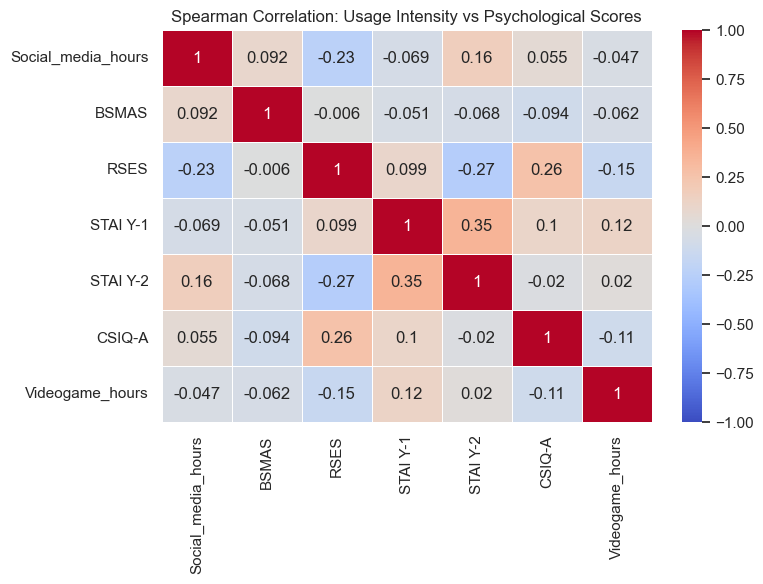

,Spearman_r
STAI Y-2,0.164650
BSMAS,0.091604
CSIQ-A,0.054561
Videogame_hours,-0.046598
STAI Y-1,-0.069470
RSES,-0.233914


In [11]:
numeric_focus = [
    "Social_media_hours","BSMAS","RSES","STAI Y-1","STAI Y-2","CSIQ-A","Videogame_hours"
 ]
available_numeric = [col for col in numeric_focus if col in df.columns]

spearman_matrix = df[available_numeric].corr(method="spearman")
display(spearman_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Spearman Correlation: Usage Intensity vs Psychological Scores")
plt.tight_layout()
plt.show()

if "Social_media_hours" in available_numeric:
    correlation_slice = spearman_matrix.loc[:, "Social_media_hours"].drop("Social_media_hours", errors="ignore")
    insight_table = correlation_slice.sort_values(ascending=False).to_frame(name="Spearman_r")
    display(insight_table)

## 8. BSMAS Segmentation Profiles
Identify behavioral and psychological patterns across low/medium/high BSMAS score tiers.

In [ ]:
profile_columns = [
    "Age","Social_media_hours","RSES","STAI Y-1","STAI Y-2","CSIQ-A","Videogame_hours"
 ]
required_cols = ["BSMAS"] + [col for col in profile_columns if col in df.columns]

missing_profile_cols = set(required_cols) - set(df.columns)
if missing_profile_cols:
    print(f"Segmentation skipped: columns missing -> {sorted(missing_profile_cols)}")
else:
    segment_df = df[required_cols].dropna().copy()
    if segment_df.empty:
        print("Segmentation skipped: insufficient complete rows across profiling columns.")
    else:
        unique_scores = segment_df["BSMAS"].nunique()
        labels = ["Low","Medium","High"]
        if unique_scores >= 3:
            segment_df["BSMAS_Segment"] = pd.qcut(segment_df["BSMAS"], 3, labels=labels)
        else:
            segment_df["BSMAS_Segment"] = pd.cut(
                segment_df["BSMAS"], bins=3, labels=labels, include_lowest=True
            )
        segment_counts = segment_df["BSMAS_Segment"].value_counts().sort_index()
        print("Segment counts:")
        display(segment_counts.to_frame(name="n"))

        segment_means = segment_df.groupby("BSMAS_Segment")[profile_columns].mean()
        segment_medians = segment_df.groupby("BSMAS_Segment")[profile_columns].median()
        print("Mean profile by BSMAS segment:")
        display(segment_means)
        print("Median profile by BSMAS segment:")
        display(segment_medians)

        zscore_means = segment_means.apply(
            lambda col: (col - col.mean()) / col.std(ddof=0) if col.std(ddof=0) > 0 else 0
        )
        plt.figure(figsize=(8, 4))
        sns.heatmap(
            zscore_means, annot=True, cmap="coolwarm", center=0, linewidths=0.5
        )
        plt.title("Z-Scored Means by BSMAS Segment")
        plt.ylabel("BSMAS Segment")
        plt.tight_layout()
        plt.show()

## 9. Continuous Outcome Modelling
Regress the raw BSMAS score on demographic and psychological predictors to quantify effect sizes.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

regression_features = [
    "Age","Sex","Social_media_hours","RSES","STAI Y-1","STAI Y-2","CSIQ-A","Videogame_hours"
 ]
required_reg_cols = [col for col in regression_features if col in df.columns] + ["BSMAS"]

missing_reg_cols = set(["BSMAS"]) - set(df.columns)
if missing_reg_cols:
    print(f"Regression skipped: columns missing -> {sorted(missing_reg_cols)}")
else:
    reg_df = df[[col for col in required_reg_cols if col in df.columns]].dropna().copy()
    if reg_df.empty:
        print("Regression skipped: insufficient complete rows across predictors and target.")
    else:
        if "Sex" in reg_df.columns:
            reg_df = reg_df[reg_df["Sex"].isin(["Male","Female"])]
            reg_df["Sex_numeric"] = reg_df["Sex"].map({"Male": 0, "Female": 1})
            feature_cols = [col for col in required_reg_cols if col not in {"Sex","BSMAS"}] + ["Sex_numeric"]
        else:
            feature_cols = [col for col in required_reg_cols if col != "BSMAS"]

        cleaned_df = reg_df.dropna(subset=feature_cols + ["BSMAS"])
        if cleaned_df.empty:
            print("Regression skipped: class filtering removed all rows.")
        else:
            X_reg = cleaned_df[feature_cols]
            y_reg = cleaned_df["BSMAS"]

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_reg)

            lin_reg = LinearRegression()
            r2_scores = cross_val_score(lin_reg, X_scaled, y_reg, cv=5, scoring="r2")
            rmse_scores = np.sqrt(-cross_val_score(lin_reg, X_scaled, y_reg, cv=5, scoring="neg_mean_squared_error"))

            print("5-fold CV R^2:")
            print(pd.Series(r2_scores).describe()[["mean","std","min","max"]])
            print("\n5-fold CV RMSE:")
            print(pd.Series(rmse_scores).describe()[["mean","std","min","max"]])

            lin_reg.fit(X_scaled, y_reg)
            coef_df = pd.DataFrame({
                "Feature": feature_cols,
                "Standardized_Coefficient": lin_reg.coef_
            }).sort_values("Standardized_Coefficient", ascending=False)
            print("\nStandardized coefficients (higher magnitude = stronger effect):")
            display(coef_df)
            print(f"Intercept (BSMAS mean when standardized predictors are 0): {lin_reg.intercept_:.2f}")